## **LIME** (LOCAL INTERPRETABLE MODEL-AGNOSTIC EXPLANATIONS)

In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

In [55]:
model = models.get_model("inception_v3", weights="DEFAULT")# initailizing inception-v3 a pretrained model with default weights
weights = models.Inception_V3_Weights.DEFAULT
preprocess = weights.transforms() # For preprocessign and transformation

In [5]:
img = Image.open('/content/drive/MyDrive/archive/testA/n02381460_1110.jpg').convert('RGB')
img_np = np.array(img)
# Convert the NumPy array to a PyTorch tensor
img = torch.tensor(img_np)
img = img.permute(2,0,1)
img.shape

torch.Size([3, 256, 256])

In [7]:
preprocessed_image_for_slic = img.permute(1, 2, 0).contiguous().numpy() # Convert image in the accordance of slic algorithm
segments = torch.tensor(slic(preprocessed_image_for_slic, n_segments=50, compactness=10, sigma=1))
segments.shape

torch.Size([256, 256])

In [8]:
number_of_segments = torch.tensor(np.unique(segments))
number_of_segments # Forming the array of segment labels

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41])

In [9]:
interpretable_vector = torch.ones_like(number_of_segments, dtype = torch.int64)
interpretable_vector # Vector easily interpretable by humans

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
Number_samples = 20
Z = []  # Interpretable binary vectors
Z_images = []  # Perturbed input images
for _ in range(Number_samples):
    mask = torch.ones_like(number_of_segments, dtype = torch.int64) # initializing the interpretable vector
    num_masked = torch.randint(len(interpretable_vector)+1, (1,)).item() # total number of indices should be masked out
    indexs = torch.randint(len(interpretable_vector), (num_masked,)) # indices that will masked out
    mask[indexs] = 0

    clone = segments.clone() # cloning the segment vector
    masked = torch.isin(clone,number_of_segments[mask ==0])
    perturbed_image = img.clone()
    perturbed_image[:, masked] = 0 # creating masked image
    Z.append(mask)
    Z_images.append(perturbed_image)

In [11]:
Z_images_tensor = torch.stack(Z_images) # stacking each Z_images tensors to form new dimension
Z_images_tensor.shape

torch.Size([20, 3, 256, 256])

In [13]:
model.eval()
with torch.no_grad():
  preprocessed_image_tensor = preprocess(Z_images_tensor) # Preprocessing the images suitable for the model
  pridictions = model(preprocessed_image_tensor) # making predictions for the pretubrated images
  pridictions.shape

In [14]:
# Computing the distances between original image interpretable vectore and pretubrated image interpretable vector
def compute_kernel(x_mask, z_mask, sigma=4.0):
    x_flat = x_mask.view(-1).float()
    z_flat = z_mask.view(-1).float()
    distance = torch.norm(x_flat - z_flat, p=2)
    return torch.exp(-(distance ** 2) / (sigma ** 2))

weights = torch.tensor([compute_kernel(torch.ones_like(number_of_segments, dtype=torch.int64), z_i) for z_i in Z])  # shape: [N_samples]

In [15]:
weights

tensor([0.2375, 0.2528, 0.7788, 0.2096, 0.6065, 0.8290, 0.2528, 0.4724, 0.5028,
        0.4724, 0.1850, 0.2231, 0.8290, 0.3456, 0.8290, 0.1850, 0.2375, 0.2096,
        0.1969, 0.8290])

In [16]:
target_label = 339
y = pridictions[:, target_label] # 339 is the label for horse and our image is also a horse

In [17]:
# Training a linear model to get to know about which super pixels have affected the prediction most!
from sklearn.linear_model import Lasso
import torch

X = torch.stack([z.float().view(-1) for z in Z]).numpy()
Y = y.numpy()
W = weights.numpy()

model_2 = Lasso(alpha = 0.01)
model_2.fit(X, Y, sample_weight=W)
coefficients = model_2.coef_

In [18]:
top_indices = coefficients.argsort()[::-1][:10] + 1
print("Top contributing segments:", top_indices)

Top contributing segments: [18 22  8 24 32  1  9 14  2 27]


In [19]:
new_mask = torch.isin(clone,torch.tensor(top_indices))
image_important_part = img.clone()
image_important_part[:, ~new_mask] = 0

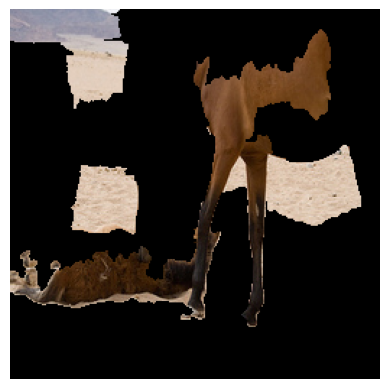

In [20]:
# Pixles which have a good impact on prediction that this is the image of the horse are shown in this masked image
image_important_part = image_important_part.permute(1,2,0)
plt.imshow(image_important_part)
plt.axis('off')
plt.show()

In [75]:
# Converting Everything above into a function for direct use case
def LIME(path, model, preprocess, Number_samples = 20, n_segments = 50):
  img = Image.open(path).convert('RGB').resize((228,228))
  img_np = np.array(img)
  img = torch.tensor(img_np)
  img = img.permute(2,0,1)

  preprocessed_image_for_slic = img.permute(1, 2, 0).contiguous().numpy()
  segments = torch.tensor(slic(preprocessed_image_for_slic, n_segments, compactness=10, sigma=1, enforce_connectivity=False))
  number_of_segments = torch.tensor(np.unique(segments))
  interpretable_vector = torch.ones_like(number_of_segments, dtype = torch.int64)

  Z = []  # Interpretable binary vectors
  Z_images = []  # Perturbed input images

  for _ in range(Number_samples):
      mask = torch.ones_like(number_of_segments, dtype = torch.int64)
      num_masked = torch.randint(len(interpretable_vector)+1, (1,)).item()
      indexs = torch.randint(len(interpretable_vector), (num_masked,))
      mask[indexs] = 0

      clone = segments.clone()
      masked = torch.isin(clone,number_of_segments[mask ==0])
      perturbed_image = img.clone()
      perturbed_image[:, masked] = 0
      Z.append(mask)
      Z_images.append(perturbed_image)

  Z_images_tensor = torch.stack(Z_images)
  model.eval()
  with torch.no_grad():
    real_preprocessed_image = preprocess(img)
    output = model(real_preprocessed_image.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class_index = torch.argmax(probabilities, dim=1)
    preprocessed_image_tensor = preprocess(Z_images_tensor)
    pridictions = model(preprocessed_image_tensor)

  weights = torch.tensor([compute_kernel(torch.ones_like(number_of_segments, dtype=torch.int64), z_i) for z_i in Z])
  y = pridictions[:, predicted_class_index]

  X = torch.stack([z.float().view(-1) for z in Z]).numpy()
  Y = y.numpy()
  W = weights.numpy()

  model_2 = Lasso(alpha = 0.01)
  model_2.fit(X, Y, sample_weight=W)
  coefficients = model_2.coef_
  return coefficients, clone

# Submodular pick (SP) algorithm

In [34]:
#importing the path of ten selected images
import os
import glob
image_dir = "/content/drive/MyDrive/images"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
image_paths

['/content/drive/MyDrive/images/9.jpg',
 '/content/drive/MyDrive/images/5.jpg',
 '/content/drive/MyDrive/images/10.jpg',
 '/content/drive/MyDrive/images/2.jpg',
 '/content/drive/MyDrive/images/8.jpg',
 '/content/drive/MyDrive/images/7.jpg',
 '/content/drive/MyDrive/images/1.jpg',
 '/content/drive/MyDrive/images/6.jpg',
 '/content/drive/MyDrive/images/3.jpg',
 '/content/drive/MyDrive/images/4.jpg']

In [73]:
# Initializing the wight matrix and cloned images
matrix_weight = []
cloned_images = []

In [76]:
# Passing path to the above fucntion and storign the result into the weight matrix
for path in image_paths:
  coefficients, clone = LIME(path, model, preprocess)
  matrix_weight.append(coefficients)
  cloned_images.append(clone)

In [77]:
matrix_weight = torch.tensor(matrix_weight)
matrix_weight.shape

torch.Size([10, 49])

In [86]:
matrix_weight

tensor([[ 0.0000e+00,  2.8906e-01,  4.1045e-01,  1.8396e+00,  0.0000e+00,
          1.3218e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.5239e-01,
          1.0627e+00,  0.0000e+00,  5.3756e-01,  1.9961e+00,  0.0000e+00,
          6.2384e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.4726e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2926e-04,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0601e-01,
          1.7204e+00,  1.2859e+00,  0.0000e+00,  3.9497e-01,  2.4327e-01,
          9.8427e-01,  0.0000e+00, -0.0000e+00, -0.0000e+00,  5.4766e-01,
          0.0000e+00,  0.0000e+00,  2.4512e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  7.0415e-01, -0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.5616e+00,  4.1902e-01,  7.7575e-01,  1.1947e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -9.3076e-01, -0.0000e+00,
          0.0000e+00,  0.0000e+00, -0.0000e+00,  7.6149e-01,  0.0000e+00,
          0.0000e+00, -0.0000e+00,  1.5992e+00,  0

In [85]:
# Calculating the importance matrix(global importance) for all the features (in this case we have 50 superpixles so 50 features)
weights_sum_matrix = torch.abs(matrix_weight).sum(dim=0)
Importnace_matrix = torch.sqrt(weights_sum_matrix)
Importnace_matrix

tensor([1.6320, 2.0336, 1.6920, 2.1453, 2.1420, 1.7827, 0.8557, 1.4624, 1.1041,
        1.6887, 2.0138, 1.7490, 1.1863, 1.9726, 1.3227, 1.0286, 1.0878, 2.4436,
        3.0942, 1.6691, 2.0147, 1.0320, 1.4299, 1.8120, 1.8033, 2.3941, 2.0696,
        1.1182, 1.2025, 1.6621, 2.3960, 2.4072, 2.0067, 0.6285, 0.7120, 1.5239,
        1.9319, 1.0699, 1.7152, 2.3836, 1.0306, 1.1754, 1.3886, 1.8012, 1.7218,
        1.3123, 1.4728, 2.1535, 0.8590])

In [87]:
# Defining the set function which calcuate the coverage of each instances present in set V
def set_C(V, W, I):
  value = 0
  sum = 0
  for index, score in enumerate(I):
    for j in V:
      if W[j][index] > 0:
        value = 1
        break
      else:
        value = 0
    sum = sum + value*score
  return sum

In [91]:
# Finding the best 5 examples which after analysing using LIME algorithm will give the better understanding of the complete model
B = 5
V = set()
while len(V) < B:
    all_score = []
    candidates = list(set(range(len(image_paths))) - V)  # Only consider unused indices

    for i in candidates:
        temp_V = V | {i}  # temporary set with i added
        score = set_C(temp_V, matrix_weight, Importnace_matrix)
        all_score.append(score)

    best_i = candidates[all_score.index(max(all_score))]  # best i from candidates
    V.add(best_i)  # now update the real V
print(V)

{0, 1, 3, 6, 7}


### So we get {0, 1, 3, 6, 7} images in my path which have high coverage of features and after analysing using LIME give better understanding about model